In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

In [ ]:
train_dir = '/content/drive/MyDrive/FER-2013/input/train/'
test_dir = '/content/drive/MyDrive/FER-2013/input/test/'

row, col = 48, 48
classes = 6

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  fear  happy  neutral  sad  surprise
train    507   248    310      500  266       399
      surprise  sad  neutral  happy  fear  angry
test        66   53       81     47    56     48


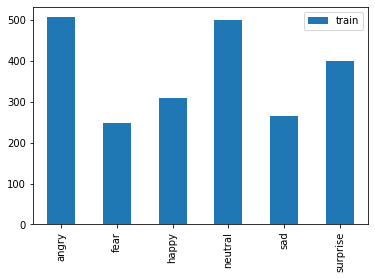

In [ ]:
train_count.transpose().plot(kind='bar')

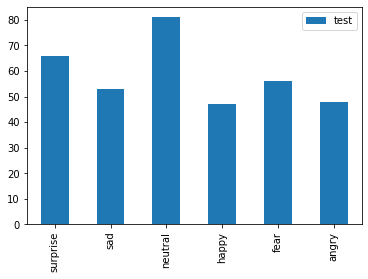

In [ ]:
test_count.transpose().plot(kind='bar')

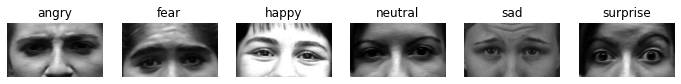

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 2230 images belonging to 6 classes.
Found 351 images belonging to 6 classes.


In [ ]:
training_set.class_indices

{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

In [ ]:
def model_1(input_size, classes=6):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [ ]:
fernet = model_1((row,col,1), classes)
fernet.summary()

In [ ]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

In [ ]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

model_1_hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
34/34 [==============================] - ETA: 0s - loss: 6.1333 - accuracy: 0.3444 
Epoch 1: val_loss improved from inf to 4.32311, saving model to ferNet.h5
34/34 [==============================] - 1675s 49s/step - loss: 6.1333 - accuracy: 0.3444 - val_loss: 4.3231 - val_accuracy: 0.1875 - lr: 1.0000e-04
Epoch 2/60
34/34 [==============================] - ETA: 0s - loss: 4.0941 - accuracy: 0.4515
Epoch 2: val_loss improved from 4.32311 to 4.31779, saving model to ferNet.h5
34/34 [==============================] - 8s 225ms/step - loss: 4.0941 - accuracy: 0.4515 - val_loss: 4.3178 - val_accuracy: 0.2031 - lr: 1.0000e-04
Epoch 3/60
34/34 [==============================] - ETA: 0s - loss: 3.7718 - accuracy: 0.5088
Epoch 3: val_loss did not improve from 4.31779
34/34 [==============================] - 7s 191ms/step - loss: 3.7718 - accuracy: 0.5088 - val_loss: 4.3468 - val_accuracy: 0.1906 - lr: 1.0000e-04
Epoch 4/60
34/34 [==============================] - ETA: 0s - loss: 3.651

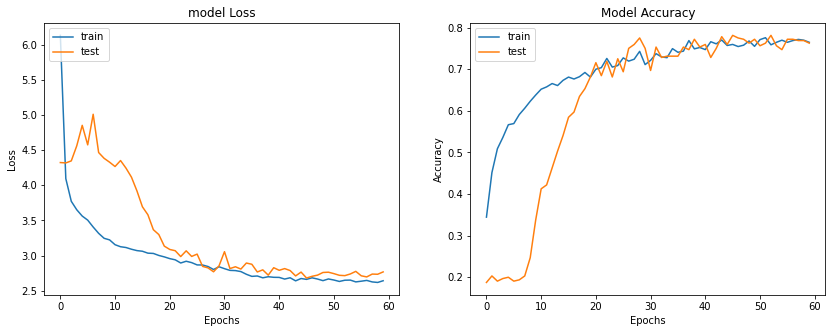

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(model_1_hist.history['accuracy'])
plt.plot(model_1_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(model_1_hist.history['loss'])
plt.plot(model_1_hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

6/6 [==============================] - 1s 155ms/step - loss: 2.7365 - accuracy: 0.7692
final train accuracy = 77.67 , validation accuracy = 76.92


In [ ]:
fernet.save_weights('fernet_bestweight.h5')

Confusion Matrix
[[107  72  45  95  77 111]
 [ 52  42  23  45  36  50]
 [ 66  46  27  59  45  67]
 [ 89  68  53  97  81 112]
 [ 59  41  32  51  33  50]
 [ 95  49  34  74  49  98]]
Classification Report
              precision    recall  f1-score   support

       angry       0.23      0.21      0.22       507
        fear       0.13      0.17      0.15       248
       happy       0.13      0.09      0.10       310
     neutral       0.23      0.19      0.21       500
         sad       0.10      0.12      0.11       266
    surprise       0.20      0.25      0.22       399

    accuracy                           0.18      2230
   macro avg       0.17      0.17      0.17      2230
weighted avg       0.18      0.18      0.18      2230



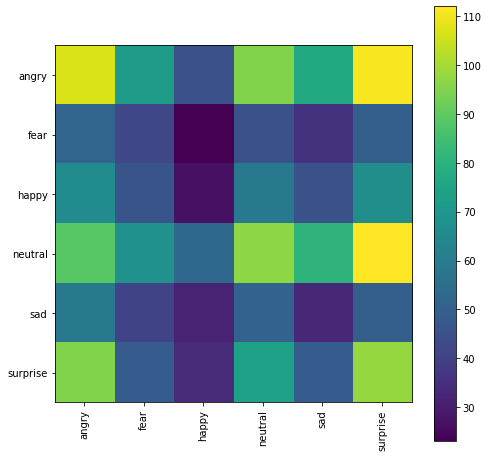

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix
[[13 12  3  3  6 11]
 [ 5 13  1  9  7 21]
 [ 5  8  7  8  6 13]
 [12  9  6 16 11 27]
 [ 8 11  3  7  5 19]
 [ 5 22  8 10  2 19]]
Classification Report
              precision    recall  f1-score   support

       angry       0.27      0.27      0.27        48
        fear       0.17      0.23      0.20        56
       happy       0.25      0.15      0.19        47
     neutral       0.30      0.20      0.24        81
         sad       0.14      0.09      0.11        53
    surprise       0.17      0.29      0.22        66

    accuracy                           0.21       351
   macro avg       0.22      0.21      0.20       351
weighted avg       0.22      0.21      0.21       351



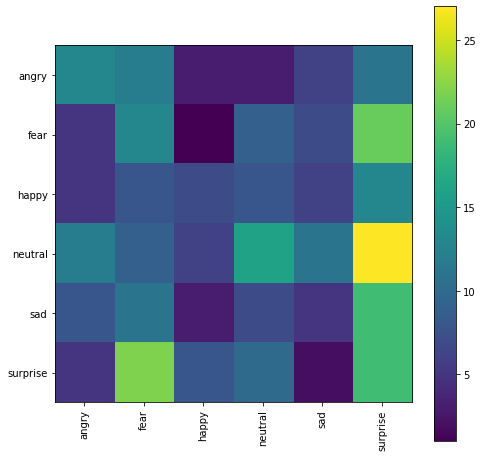

In [ ]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)